# Final Project - Enterprise Data Science

### Kaggle's Amazon - Employee Access Challenge Dataset

URL: https://www.kaggle.com/c/amazon-employee-access-challenge

### Overview

When an employee at any company starts work, they first need to obtain the computer access necessary to fulfill their role. This access may allow an employee to read/manipulate resources through various applications or web portals. It is assumed that employees fulfilling the functions of a given role will access the same or similar resources. It is often the case that employees figure out the access they need as they encounter roadblocks during their daily work (e.g. not able to log into a reporting portal). A knowledgeable supervisor then takes time to manually grant the needed access in order to overcome access obstacles. As employees move throughout a company, this access discovery/recovery cycle wastes a nontrivial amount of time and money.

There is a considerable amount of data regarding an employee’s role within an organization and the resources to which they have access. Given the data related to current employees and their provisioned access, models can be built that automatically determine access privileges as employees enter and leave roles within a company. These auto-access models seek to minimize the human involvement required to grant or revoke employee access.

### Objective

The objective of this competition is to build a model, learned using historical data, that will determine an employee's access needs, such that manual access transactions (grants and revokes) are minimized as the employee's attributes change over time. The model will take an employee's role information and a resource code and will return whether or not access should be granted.

In [213]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
#import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cross_validation import KFold;
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve

from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [214]:
## Read the dataset

train = pd.read_csv('amazon/train.csv')
test = pd.read_csv('amazon/test.csv')

# Store our passenger ID for easy access
ID = test['id']
print(train.shape, test.shape)
train.info()
#print(train.isnull().sum(), test.isnull().sum())

(32769, 10) (58921, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
ACTION              32769 non-null int64
RESOURCE            32769 non-null int64
MGR_ID              32769 non-null int64
ROLE_ROLLUP_1       32769 non-null int64
ROLE_ROLLUP_2       32769 non-null int64
ROLE_DEPTNAME       32769 non-null int64
ROLE_TITLE          32769 non-null int64
ROLE_FAMILY_DESC    32769 non-null int64
ROLE_FAMILY         32769 non-null int64
ROLE_CODE           32769 non-null int64
dtypes: int64(10)
memory usage: 2.5 MB


## Data Preprocessing: Feature Engineering

Feature Engineering by converting the categorical variables

In [215]:
# Feature selection
y = train['ACTION'].ravel()
X = train.drop(['ACTION'], axis=1)
#X = train.drop(['ACTION', 'ROLE_ROLLUP_1', 'ROLE_TITLE', 'ROLE_FAMILY'], axis=1)

X_test_org = test.drop(['id'], axis=1)
#X_test_org = test.drop(['id', 'ROLE_ROLLUP_1', 'ROLE_TITLE', 'ROLE_FAMILY'], axis=1) # Creats an array of the test data

print(X.shape, y.shape, X_test_org.shape)
X.head(5)

(32769, 9) (32769,) (58921, 9)


,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,42680,5905,117929,117930,119569,119323,123932,19793,119325


## Visualizations

### Pearson Correlation Heatmap

Let's generate some correlation plots of the features to see how related one feature is to the next. To do so, I will utilise the Seaborn plotting package which allows me to plot heatmaps very conveniently as follows:

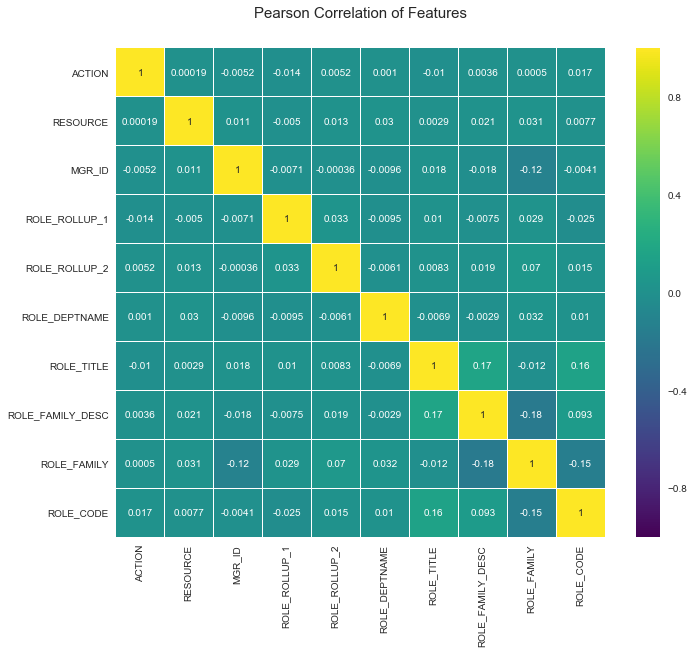

In [216]:
colormap = plt.cm.viridis
plt.figure(figsize=(11,9))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

### Pairplots

Finally let's generate some pairplots to observe the distribution of data from one feature to the other. Once again i will use Seaborn to plot it out.

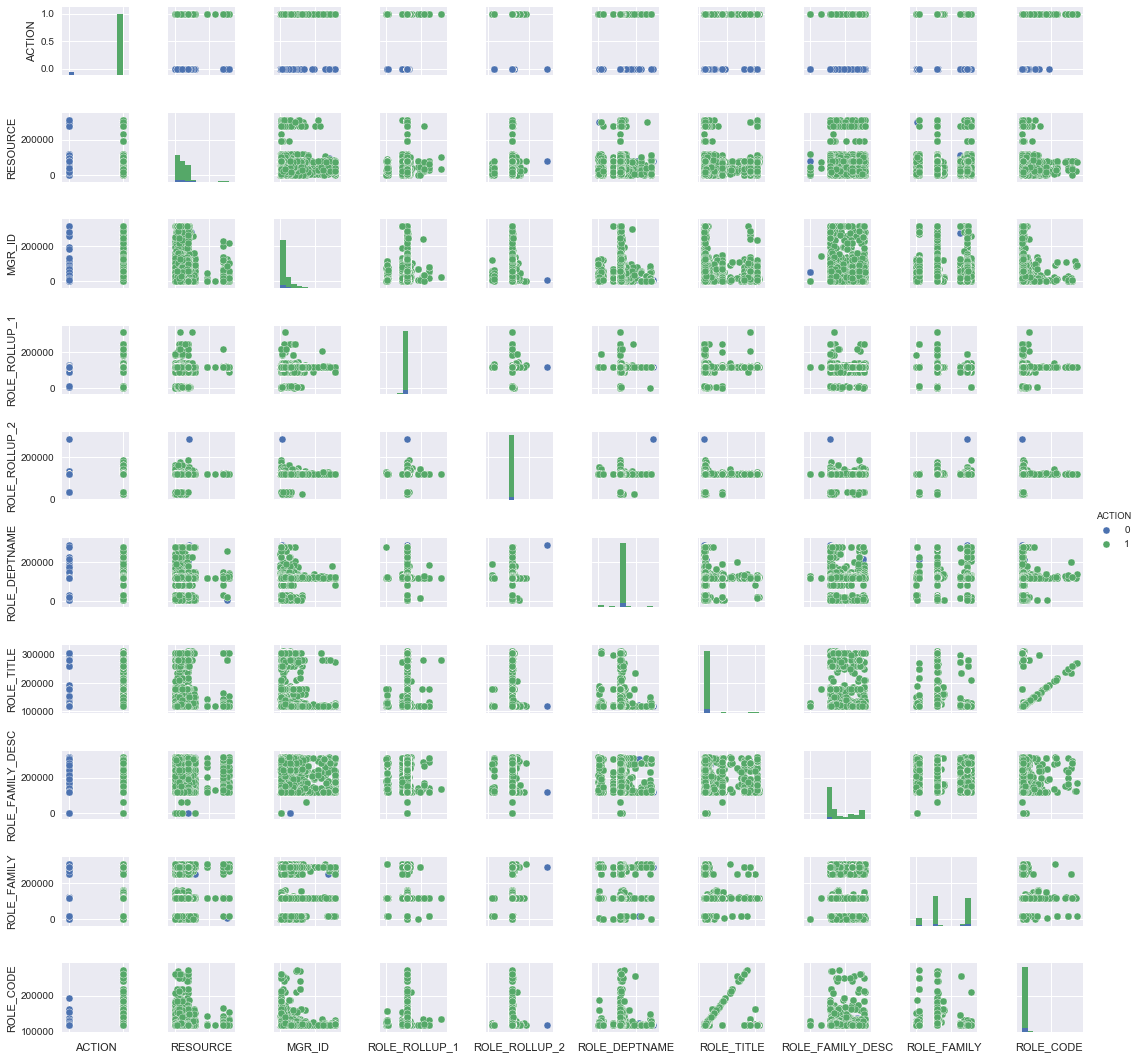

In [156]:
g = sns.pairplot(train, hue='ACTION', size=1.5)
g.set(xticklabels=[])

In [217]:
from sklearn.decomposition import PCA  # 1. Choose the model class
model = PCA(n_components=2)            # 2. Instantiate the model with hyperparameters
model.fit(X)                           # 3. Fit to data. Notice y is not specified!
X_2D = model.transform(X)              # 4. Transform the data to two dimensions

Now let's plot the results. A quick way to do this is to insert the results into the original Train DataFrame, and use Seaborn's lmplot to show the results:

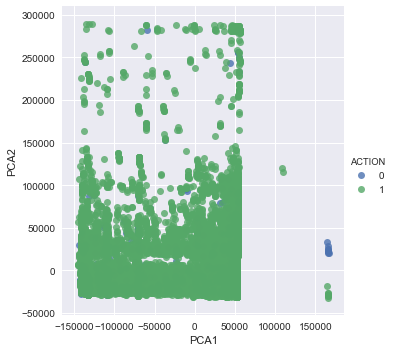

In [208]:
train['PCA1'] = X_2D[:, 0]
train['PCA2'] = X_2D[:, 1]
sns.lmplot("PCA1", "PCA2", hue='ACTION', data=train, fit_reg=False);

### Data Normalization


In [218]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = scaler.fit_transform(X)
X_test_scaler = scaler.transform(X_test_org)

X.shape, y.shape, X_test_scaler.shape

((32769, 9), (32769,), (58921, 9))

### Model validation via cross-validation
- KNN
- SVC Linear
- Random Forest
- Decision Tree
- Extra Trees
- Ada Boost
- Gradient Boosting

In [219]:
X.shape, y.shape, X_test_scaler.shape

#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((22938, 9), (22938,), (9831, 9), (9831,))

In [16]:
train_size, train_loss, test_loss = learning_curve(
    SVC(gamma=0.01), X, y, cv=10, scoring='mean_squared_error', train_sizes=[0.1, 0.25, 0.5, 0.75, 1])

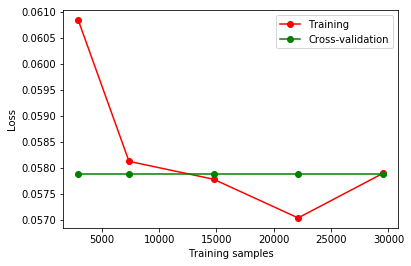

In [17]:
train_loss_mean = -np.mean(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)

plt.plot(train_size, train_loss_mean, 'o-', color ="r", label = "Training")
plt.plot(train_size, test_loss_mean, 'o-', color ="g", label = "Cross-validation")
plt.xlabel("Training samples")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

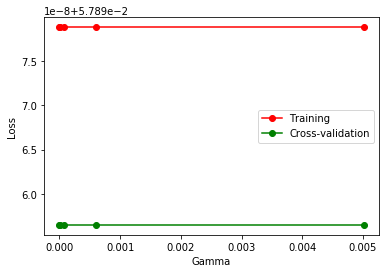

In [19]:
param_range = np.logspace(-6, -2.3, 5)
train_loss, test_loss = validation_curve(
    SVC(), X, y, param_name ='gamma', param_range = param_range, cv=10, 
    scoring='mean_squared_error')

train_loss_mean = -np.mean(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)

plt.plot(param_range, train_loss_mean, 'o-', color ="r", label = "Training")
plt.plot(param_range, test_loss_mean, 'o-', color ="g", label = "Cross-validation")
plt.xlabel("Gamma")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

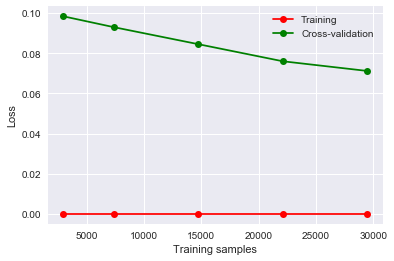

In [171]:
train_size, train_loss, test_loss = learning_curve(
    DecisionTreeClassifier(), X, y, cv=10, scoring='mean_squared_error', train_sizes=[0.1, 0.25, 0.5, 0.75, 1])

train_loss_mean = -np.mean(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)

plt.plot(train_size, train_loss_mean, 'o-', color ="r", label = "Training")
plt.plot(train_size, test_loss_mean, 'o-', color ="g", label = "Cross-validation")
plt.xlabel("Training samples")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

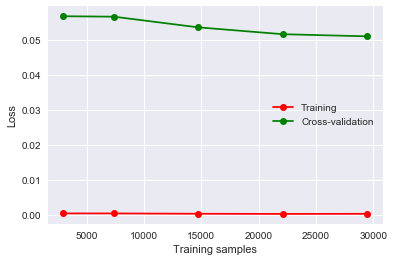

In [172]:
train_size, train_loss, test_loss = learning_curve(
    RandomForestClassifier(n_estimators=50, max_features=3), X, y, cv=10, scoring='mean_squared_error', train_sizes=[0.1, 0.25, 0.5, 0.75, 1])

train_loss_mean = -np.mean(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)

plt.plot(train_size, train_loss_mean, 'o-', color ="r", label = "Training")
plt.plot(train_size, test_loss_mean, 'o-', color ="g", label = "Cross-validation")
plt.xlabel("Training samples")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

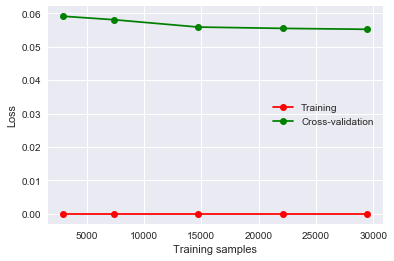

In [173]:
train_size, train_loss, test_loss = learning_curve(
    ExtraTreesClassifier(n_estimators=100, max_features=3), X, y, cv=10, scoring='mean_squared_error', train_sizes=[0.1, 0.25, 0.5, 0.75, 1])

train_loss_mean = -np.mean(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)

plt.plot(train_size, train_loss_mean, 'o-', color ="r", label = "Training")
plt.plot(train_size, test_loss_mean, 'o-', color ="g", label = "Cross-validation")
plt.xlabel("Training samples")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

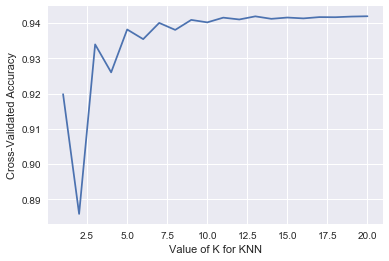

In [8]:
# KNN
k_range = range(1,21)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn_score = cross_val_score(knn, X, y, cv=10, scoring='accuracy') #for classification
    k_scores.append(knn_score.mean())

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()  

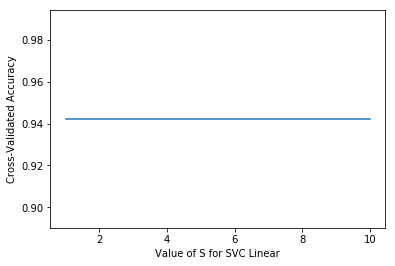

In [11]:
# SVC Linear
svc_linear_scores_range = range(1,11)
svc_linear_scores = []
for s in svc_linear_scores_range:
    svc_linear = SVC(kernel='linear', C = s)
    svc_linear_score = cross_val_score(svc_linear, X, y, cv=10, scoring='accuracy') #for classification
    svc_linear_scores.append(svc_linear_score.mean())

plt.plot(svc_linear_scores_range, svc_linear_scores)
plt.xlabel('Value of S for SVC Linear')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [18]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree_score = cross_val_score(decision_tree, X, y, cv=10, scoring='accuracy') #for classification
print(decision_tree_score)
decision_tree_score.mean()

[ 0.93471629  0.92678462  0.92859323  0.93286543  0.92767775  0.92554165
  0.92371071  0.93009768  0.93040293  0.92338217]


0.92837724692916357

## Ensembling & Stacking Models
### Output of the First level Predictions

Fit the dataset with the following models
- KNN
- SVC Linear
- RandomForestClassifier
- Decision Tree
- Extra Tree
- AdaBoostClassifier
- Gradient Boost

In [220]:
# Random Forest Classification

seed = 7
num_trees = 100
max_features = 3
kfold = model_selection.KFold(n_splits=10, random_state=seed)

model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, X, y, cv=kfold)
print("Random Forest Classification : ", results.mean())
rf_features = model.fit(X, y).feature_importances_

# Decision Tree Classification
kfold = model_selection.KFold(n_splits=10, random_state=seed)

model = DecisionTreeClassifier()
results = model_selection.cross_val_score(model, X, y, cv=kfold)
print("Decision Tree Classification : ", results.mean())
dt_features = model.fit(X, y).feature_importances_

# Extra Trees Classification
kfold = model_selection.KFold(n_splits=10, random_state=seed)

model = ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, X, y, cv=kfold)
print("Extra Trees Classification : ", results.mean())
et_features = model.fit(X, y).feature_importances_

# AdaBoost Classification
seed = 7
num_trees = 30
kfold = model_selection.KFold(n_splits=10, random_state=seed)

model = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X, y, cv=kfold)
print("AdaBoost Classification : ", results.mean())
ab_features = model.fit(X, y).feature_importances_

# Stochastic Gradient Boosting Classification

seed = 7
num_trees = 100
kfold = model_selection.KFold(n_splits=10, random_state=seed)

model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X, y, cv=kfold)
print("Stochastic Gradient Boosting Classification : ", results.mean())
gb_features = model.fit(X, y).feature_importances_

# Voting Ensemble for Classification
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)

# create the sub models
estimators = []
model1 = ExtraTreesClassifier()
estimators.append(('ExtraTrees', model1))

model2 = DecisionTreeClassifier()
estimators.append(('DecisionTree', model2))

# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X, y, cv=kfold)
print("Voting Ensemble for Classification : ", results.mean())

Random Forest Classification :  0.948548938601
Decision Tree Classification :  0.92737025884
Extra Trees Classification :  0.943483190088
AdaBoost Classification :  0.942109954942
Stochastic Gradient Boosting Classification :  0.942720306513
Voting Ensemble for Classification :  0.921877253049


### Feature Selection

Decide and select the right features for training

In [221]:
Xtrain = train.drop(['ACTION'], axis=1)
#Xtrain = train.drop(['ACTION', 'ROLE_ROLLUP_1', 'ROLE_TITLE', 'ROLE_FAMILY'], axis=1)
cols = Xtrain.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
        'Random Forest feature importances': rf_features.tolist(),
        'Decision Tree feature importances': dt_features.tolist(),
        'Extra Trees feature importances': et_features.tolist(),
        'AdaBoost feature importances': ab_features.tolist(),
        'Gradient Boosting feature importances': gb_features.tolist()
    })

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(5)

,AdaBoost feature importances,Decision Tree feature importances,Extra Trees feature importances,Gradient Boosting feature importances,Random Forest feature importances,features,mean
0,0.266667,0.404953,0.365220,0.163952,0.370388,RESOURCE,0.314236
1,0.133333,0.195093,0.166319,0.191682,0.186363,MGR_ID,0.174558
2,0.133333,0.026566,0.049175,0.074193,0.035916,ROLE_ROLLUP_1,0.063837
3,0.133333,0.064502,0.103465,0.132387,0.073490,ROLE_ROLLUP_2,0.101436
4,0.066667,0.100458,0.117037,0.095605,0.115847,ROLE_DEPTNAME,0.099123


### Plotly Barplot of Average Feature Importances

Having obtained the mean feature importance across all our classifiers, we can plot them into a Plotly bar plot as follows:

In [222]:
y_mean = feature_dataframe['mean'].values
x_features = feature_dataframe['features'].values
data = [go.Bar(
            x = x_features, y = y_mean,
            width = 0.5,
            marker=dict( color = feature_dataframe['mean'].values,
                colorscale='Portland', showscale=True, reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## Model Training 

Fit the dataset with the following models

- KNN
- SVC Linear
- Random Forest
- Decision Tree
- Extra Trees
- Ada Boost
- Gradient Boosting

In [223]:
models_name = []
training_scores = []
test_scores = []
accuracy_scores = []
roc_auc_scores = [] 
average_precision_scores = []

def clear_models_info():    
    models_name.clear()
    training_scores.clear()
    test_scores.clear()
    accuracy_scores.clear()
    roc_auc_scores.clear()
    average_precision_scores.clear()
    
def print_model(model_name, model, predict_model, X_train, y_train, X_test, y_test):
    training_score = model.score(X_train, y_train)
    #print(model_name + " R-squared score (training): ", training_score)
    test_score = model.score(X_test, y_test)
    #print(model_name + " R-squared score (test): ", test_score)
    accuracy = accuracy_score(y_test, predict_model)
    #print(model_name +  ' Accuracy score (prediction): {0:0.5f}'.format(accuracy))
    roc_auc = roc_auc_score(y_test, predict_model)
    #print(model_name +  ' ROC AUC score: {0:0.5f}'.format(roc_auc))
    average_precision = average_precision_score(y_test, predict_model)
    #print(model_name +  ' Average precision-recall score: {0:0.5f}'.format(average_precision))

    #target_names = ['class 0', 'class 1']
    #print(classification_report(y_test, predict_model, target_names=target_names))
    
    models_name.append(model_name)
    training_scores.append(training_score)
    test_scores.append(test_score)
    accuracy_scores.append(accuracy)
    roc_auc_scores.append(roc_auc)
    average_precision_scores.append(average_precision)

def plot_model(model_name, model, predict_model, X_train, y_train, X_test, y_test):
    fpr, tpr, thresholds = roc_curve(y_test, predict_model, pos_label=1)
    roc_auc = auc(fpr,tpr)
    roc_auc

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_name + ' Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    mat = confusion_matrix(y_test, predict_model)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    plt.title(model_name + ' Confusion Matrix')
    #plt.show()
    
    plt.show()

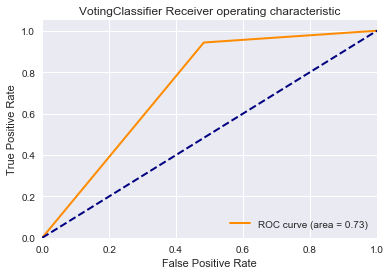

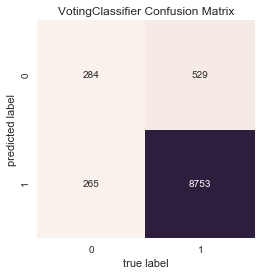

Completed!!!


In [224]:
clear_models_info()

# KNN
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test)
print_model("KNN", knn, y_knn_pred, X_train, y_train, X_test, y_test)
#plot_model("KNN", knn, y_model, X_train, y_train, X_test, y_test

# Linear SVC
svc_linear = SVC(kernel='linear', C=5).fit(X_train, y_train)
y_svc_linear_pred = svc_linear.predict(X_test) 
print_model("SVC Linear", svc_linear, y_svc_linear_pred, X_train, y_train, X_test, y_test)
#plot_model("SVC Linear", svc_linear, y_svc_linear, X_train, y_train, X_test, y_test)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_random_forest_pred = random_forest.predict(X_test)
print_model("Random Forest", random_forest, y_random_forest_pred, X_train, y_train, X_test, y_test)
#plot_model("Random Forest", random_forest, y_random_forest_pred, X_train, y_train, X_test, y_test)

# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_decision_tree_pred = decision_tree.predict(X_test)
print_model("Decision Tree", decision_tree, y_decision_tree_pred, X_train, y_train, X_test, y_test)
#plot_model("Decision Tree", decision_tree, y_decision_tree_pred, X_train, y_train, X_test, y_test)

# Extra Trees
extra_trees = ExtraTreesClassifier(n_estimators=100, max_features=3).fit(X_train, y_train)
y_extra_trees_pred = extra_trees.predict(X_test)
print_model("Extra Trees", extra_trees, y_extra_trees_pred, X_train, y_train, X_test, y_test)
#plot_model("Extra Trees", extra_trees, y_extra_trees_pred, X_train, y_train, X_test, y_test)

# Ada Boost
ada_boost = AdaBoostClassifier(n_estimators=30, random_state=7).fit(X_train, y_train)
y_ada_boost_pred = ada_boost.predict(X_test)
print_model("Ada Boost", ada_boost, y_ada_boost_pred, X_train, y_train, X_test, y_test)

# Gradient Boosting
gradient_boosting = GradientBoostingClassifier().fit(X_train, y_train)
y_gradient_boosting_pred = gradient_boosting.predict(X_test)
print_model("Gradient Boosting", gradient_boosting, y_gradient_boosting_pred, X_train, y_train, X_test, y_test)
#plot_model("Gradient Boosting", gradient_boosting, y_gradient_boosting_pred, X_train, y_train, X_test, y_test)

# create the sub models
estimators = []

model1 = ExtraTreesClassifier()
estimators.append(('ExtraTrees', model1))

model2 = DecisionTreeClassifier()
estimators.append(('DecisionTree', model2))

#model3 = RandomForestClassifier()
#estimators.append(('RandomForest', model3))

# create the ensemble model
ensemble = VotingClassifier(estimators).fit(X_train, y_train)
y_ensemble_pred = ensemble.predict(X_test)
print_model("VotingClassifier", ensemble, y_ensemble_pred, X_train, y_train, X_test, y_test)
plot_model("VotingClassifier", ensemble, y_ensemble_pred, X_train, y_train, X_test, y_test)

print("Completed!!!")

## Model Evalution

Evaluate your model using the following metrics:

- Accuracy score
- Precision and Recall Scores
- F1 score
- ROC and AUC

In [225]:
models = pd.DataFrame({
    'Model': models_name,
    'Training Score': training_scores,
    'Test Score': test_scores,
    'Score Accuracy': accuracy_scores,
    'ROC AUC Score': roc_auc_scores,
    'Score Average Precision': average_precision_scores,    
    })
models.sort_values(by='ROC AUC Score', ascending=False)

,Model,ROC AUC Score,Score Accuracy,Score Average Precision,Test Score,Training Score
7,VotingClassifier,0.730156,0.919235,0.983716,0.919235,1.000000
4,Extra Trees,0.691941,0.944156,0.982008,0.944156,1.000000
3,Decision Tree,0.690911,0.922795,0.981553,0.922795,1.000000
2,Random Forest,0.684459,0.949446,0.981705,0.949446,1.000000
0,KNN,0.519326,0.941817,0.972963,0.941817,0.942279
6,Gradient Boosting,0.504446,0.944461,0.972307,0.944461,0.942366
1,SVC Linear,0.500000,0.944156,0.972078,0.944156,0.941233
5,Ada Boost,0.500000,0.944156,0.972078,0.944156,0.941233


In [226]:
y_ROCAUC = models['ROC AUC Score'].values
x_ROCAUC = models['Model'].values
data = [go.Bar(
            x = x_ROCAUC, y = y_ROCAUC,
            width = 0.5,
            marker=dict( color = models['ROC AUC Score'].values,
                colorscale='Portland', showscale=True, reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of ROC AUC Score',
    hovermode= 'closest',
    yaxis=dict(
        title= 'ROC AUC Score',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## Prepare the submission file

Output the predictions into the proper format for submission 

In [227]:
# Decision Tree
#decision_tree = DecisionTreeClassifier().fit(X, y)
#y_decision_tree_pred = decision_tree.predict(X_test_scaler)
#y_decision_tree_pred

# create the sub models
estimators = []

model1 = ExtraTreesClassifier()
estimators.append(('ExtraTrees', model1))

model2 = DecisionTreeClassifier()
estimators.append(('DecisionTree', model2))

# create the ensemble model
ensemble = VotingClassifier(estimators).fit(X, y)
y_ensemble_pred = ensemble.predict(X_test_scaler)
y_ensemble_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [228]:
FinalSubmission = pd.DataFrame({ 
        "Id": ID,
        "Action": y_ensemble_pred })

FinalSubmission.to_csv("FinalSubmission.csv", index=False)